Для инвестирования 5 млн руб. и cтавки купона, равного 20% разработайте внебиржевой опцион “Autocallable” с ежеквартальным купоном и возможностью досрочного автоматического погашения опциона каждые 3 месяца, если на ежеквартальную купонную дату текущая цена бумаги с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance) превышает или равна барьеру отзыва.

Если продукт не был отозван досрочно, и на последнюю купонную дату текущая цена worst of превышает или равна барьеру поставки, то продукт погашается с выплатой 100% номинала. Иначе, если хотя бы один базовый актив опциона оказался ниже барьера поставки, то осуществляется выплата денежных средств в сумме, равной эквиваленту «поставки бумаги», бумаги с наибольшим снижением относительно своей первоначальной стоимости, по ее первоначальной цене.

В корзину включить четыре базовых актива, первоначальную стоимость определить на день, предшествующий дате запуска (100%). Установить барьер отзыва 105%, купонный барьер 98%, барьер поставки 90% в процентах от первоначальной стоимости каждого базового актива корзину.

**Дата запуска:** 27-07-2022.

**Дата погашения:** 25-07-2023.

**Даты ежеквартальных наблюдений:** 25-10-2022, 25-01-2023, 25-04-2023.

1. Определить действия на купонные даты (выплачивается купон; выплачивается купон с досрочным погашением продукта; не выплачивается, но запоминается; выплачивается купон за текущий и предыдущие кварталы; производится погашение продукта с «эффектом поставки»).
1. Вычислить финансовый результат по состоянию на 25-04-2023,
определить бумагу с наибольшим снижением относительно своей первоначальной стоимости.
1. Привести иллюстративные графики, на которых отобразить бумагу с наибольшим снижением относительно своей первоначальной стоимости (worst-of performance), купонные даты и действия в эти даты, уровни барьеров отзыва, поставки и купонного барьера, первоначальную стоимость актива,
провести исследование влияния уровней барьеров (барьер отзыва, купонный барьер, барьер поставки) на финансовый результат.
1. Повторить расчеты для метода оценки базовых активов -- средневзвешенная динамика стоимости всех активов (average-of perfomance).

[Примеры графиков и расчетов.](https://www.open-broker.com/files/Presentation_OTC-Option_Autocallable_.pdf)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Actions taken during observation dates:
No Coupon (2022-07-27)
No Coupon (2022-10-25)
No Coupon (2023-01-25)
No Coupon (2023-04-25)
Final Redemption with Delivery (2023-07-25)
Final Payout: 4444299.50 rubles
Profit/Loss: -555700.50 rubles


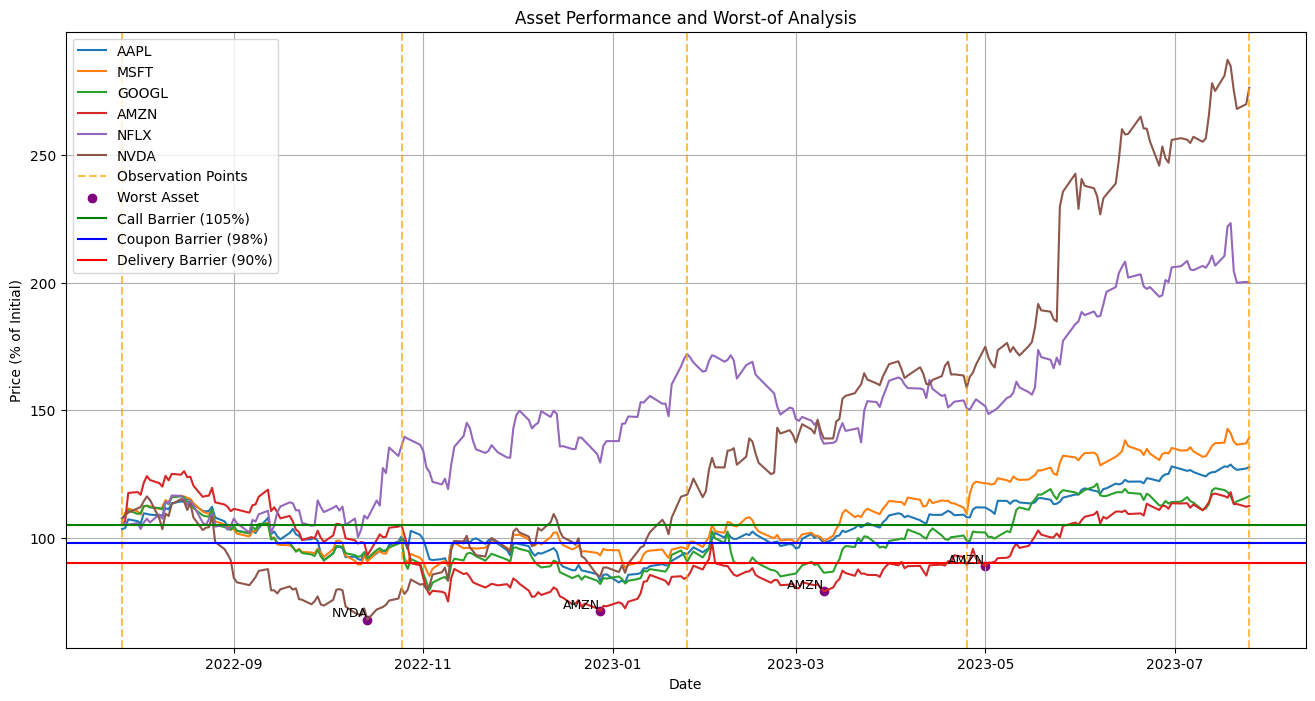

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf


class InvestmentCalculator:
    def __init__(self, investment, annual_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates):
        self.investment = investment
        self.quarterly_coupon_rate = annual_coupon_rate / 4
        self.call_barrier = call_barrier
        self.coupon_barrier = coupon_barrier
        self.delivery_barrier = delivery_barrier
        self.observation_dates = observation_dates

    @staticmethod
    def download_data(assets, start_date, end_date):
        stock_data = {}
        for asset in assets:
            try:
                asset_prices = yf.download(asset, start=start_date, end=end_date)['Close']
                if not asset_prices.empty:
                    stock_data[asset] = asset_prices
                else:
                    print(f"Data unavailable for {asset}.")
            except Exception as e:
                print(f"Error fetching data for {asset}: {e}")

        if stock_data:
            combined_data = pd.concat(stock_data, axis=1)
            combined_data.columns = assets
            return combined_data
        else:
            raise ValueError("No valid data fetched for the given parameters.")

    @staticmethod
    def calculate_worst_of(data, initial_prices, observation_dates):
        initial_prices = pd.Series(initial_prices)
        worst_of_metrics = {"values": [], "assets": [], "prices": [], "dates": []}

        for i in range(1, len(observation_dates)):
            interval_data = data.loc[observation_dates[i-1]:observation_dates[i]]
            min_values = interval_data.min(axis=0)
            performance = min_values / initial_prices
            worst_asset = performance.idxmin()

            worst_of_metrics["values"].append(performance.min())
            worst_of_metrics["assets"].append(worst_asset)
            worst_of_metrics["prices"].append(interval_data[worst_asset].min())
            worst_of_metrics["dates"].append(interval_data[worst_asset].idxmin())

        return worst_of_metrics

    def calculate_payout(self, worst_of):
        payouts = {"total": 0, "coupons": [], "actions": [], "profit_loss": 0}
        redeemed = False

        for i, wo in enumerate(worst_of["values"]):
            if wo >= self.call_barrier:
                payouts["total"] = self.investment + self.investment * self.quarterly_coupon_rate * (i + 1)
                payouts["coupons"].append(self.quarterly_coupon_rate * (i + 1))
                payouts["actions"].append(f"Early Redemption ({self.observation_dates[i]})")
                redeemed = True
                break
            elif wo >= self.coupon_barrier:
                payouts["coupons"].append(self.quarterly_coupon_rate)
                payouts["actions"].append(f"Coupon Paid ({self.observation_dates[i]})")
            else:
                payouts["coupons"].append(0)
                payouts["actions"].append(f"No Coupon ({self.observation_dates[i]})")

        if not redeemed:
            if worst_of["values"][-1] >= self.delivery_barrier:
                payouts["total"] = self.investment + self.investment * sum(payouts["coupons"])
                payouts["actions"].append(f"Final Redemption with Principal ({self.observation_dates[-1]})")
            else:
                payouts["total"] = self.investment * worst_of["values"][-1]
                payouts["actions"].append(f"Final Redemption with Delivery ({self.observation_dates[-1]})")

        # Calculate profit or loss
        payouts["profit_loss"] = payouts["total"] - self.investment
        return payouts


    def plot_worst_of(self, data, initial_prices, worst_of):
        plt.figure(figsize=(16, 8))
        for asset in data.columns:
            plt.plot(data.index, data[asset] / initial_prices[asset] * 100, label=asset, linestyle='-')

        for obs_date in self.observation_dates:
            plt.axvline(pd.to_datetime(obs_date), color='orange', linestyle='--', alpha=0.7, label='Observation Points' if obs_date == self.observation_dates[0] else "")

        for date, price, asset in zip(worst_of["dates"], worst_of["prices"], worst_of["assets"]):
            percentage = (price / initial_prices[asset]) * 100
            plt.scatter(date, percentage, color='purple', label='Worst Asset' if date == worst_of["dates"][0] else "")
            plt.text(date, percentage, asset, fontsize=9, ha='right', va='bottom')

        plt.axhline(self.call_barrier * 100, color='green', linestyle='-', label='Call Barrier (105%)')
        plt.axhline(self.coupon_barrier * 100, color='blue', linestyle='-', label='Coupon Barrier (98%)')
        plt.axhline(self.delivery_barrier * 100, color='red', linestyle='-', label='Delivery Barrier (90%)')

        plt.title('Asset Performance and Worst-of Analysis')
        plt.xlabel('Date')
        plt.ylabel('Price (% of Initial)')
        plt.legend()
        plt.grid()
        plt.show()


# Parameters and execution
investment = 5000000
annual_coupon_rate = 0.2
call_barrier = 1.05
coupon_barrier = 0.98
delivery_barrier = 0.90
observation_dates = ['2022-07-27', '2022-10-25', '2023-01-25', '2023-04-25', '2023-07-25']
assets = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NFLX', 'NVDA']

calculator = InvestmentCalculator(investment, annual_coupon_rate, call_barrier, coupon_barrier, delivery_barrier, observation_dates)
data = calculator.download_data(assets, '2022-07-26', '2023-07-26')
initial_prices = data.iloc[0].to_dict()
data = data.iloc[1:]

# Calculate worst-of metrics and payouts
worst_of_metrics = calculator.calculate_worst_of(data, initial_prices, observation_dates)
payout_result = calculator.calculate_payout(worst_of_metrics)

# Print actions and results
print("Actions taken during observation dates:")
for action in payout_result["actions"]:
    print(action)
print(f"Final Payout: {payout_result['total']:.2f} rubles")
print(f"Profit/Loss: {payout_result['profit_loss']:.2f} rubles")

# Plot results
calculator.plot_worst_of(data, initial_prices, worst_of_metrics)
